In [24]:
%pylab inline
import geopandas as gpd
import pandas as pd
import os
# !pip install mplleaflet
import mplleaflet

Populating the interactive namespace from numpy and matplotlib


In [25]:
fish_pass = 'ADFG/ADFG_fish_passage.shp'
fp = gpd.read_file(fish_pass)
regs = 'HUC8_rebuild/output/sasap_regions.shp'
regions = gpd.read_file(regs)

In [26]:
fp = fp.to_crs(epsg=3338)
regions = regions.to_crs(epsg=3338)

In [27]:
fp.RGGRating.head()

0      Red
1    Green
2      Red
3    Green
4      Red
Name: RGGRating, dtype: object

In [28]:
fp.RGGRating.count()

2930

Create a fish passage GeoDataFrame representing geometry and RGGRating only

In [29]:
fp2 = fp[['geometry', 'RGGRating']]
fp2.head(5)

,geometry,RGGRating
0,POINT (83811.68299580242 819266.9230174191),Red
1,POINT (213872.4420121688 2252881.915418045),Green
2,POINT (213536.4334304724 2250613.46924101),Red
3,POINT (207221.6008933302 2235195.704555049),Green
4,POINT (210232.879883608 2156742.824674348),Red


Spatialy join SASAP region gdf with the above fish passage gdf

In [30]:
reg_rgg = gpd.sjoin(fp2, regions, op='within').drop('index_right', axis='columns')

In [31]:
reg_rgg.head()

,geometry,RGGRating,region_id,region
0,POINT (83811.68299580242 819266.9230174191),Red,6,Kodiak
2220,POINT (80366.30333690392 874133.2270201525),Gray,6,Kodiak
2221,POINT (79595.26420932778 873985.3460359153),Red,6,Kodiak
2222,POINT (91562.86612378767 871690.9983501389),Red,6,Kodiak
2223,POINT (81048.90137418527 871092.781904645),Black,6,Kodiak


Group by region and RGGRating

In [32]:
foo = reg_rgg.drop('region_id', axis='columns').groupby(['region','RGGRating'])


Counts by region and RGGRating multiindex 

In [33]:
foo_ct = foo.count()
foo_ct.head()

geometry
region           RGGRating          
Aleutian Islands                   1
                 Black            48
                 Gray             22
                 Green             8
                 Red              32

Unstack by RGGRating and join by region

In [34]:
us = foo_ct.unstack('RGGRating')
us.columns = us.columns.get_level_values(1)
jn = us.join(regions.set_index('region'), on='region', how='outer')
jn.head()

,,Black,Gray,Green,Red,region_id,geometry
region,,,,,,,
Aleutian Islands,1.0,48.0,22.0,8.0,32.0,1,(POLYGON ((-1156665.959195634 420855.093106978...
Arctic,NaN,3.0,8.0,13.0,8.0,2,"POLYGON ((571289.9424044377 2143072.479559345,..."
Bristol Bay,NaN,6.0,7.0,5.0,7.0,3,(POLYGON ((-339688.5870041371 973904.876117813...
Cook Inlet,1.0,72.0,213.0,302.0,474.0,9,"(POLYGON ((35214.97605528703 1002456.87086566,..."
Copper River,NaN,NaN,62.0,31.0,112.0,5,"POLYGON ((561012.0068005103 1148300.750064242,..."


Sum red and gray 

In [36]:
jn['RedandGray'] = (jn.Gray + jn.Red)

In [37]:
drp_na = jn.fillna(0)
drp_na

,,Black,Gray,Green,Red,region_id,geometry,RedandGray
region,,,,,,,,
Aleutian Islands,1.0,48.0,22.0,8.0,32.0,1,(POLYGON ((-1156665.959195634 420855.093106978...,54.0
Arctic,0.0,3.0,8.0,13.0,8.0,2,"POLYGON ((571289.9424044377 2143072.479559345,...",16.0
Bristol Bay,0.0,6.0,7.0,5.0,7.0,3,(POLYGON ((-339688.5870041371 973904.876117813...,14.0
Cook Inlet,1.0,72.0,213.0,302.0,474.0,9,"(POLYGON ((35214.97605528703 1002456.87086566,...",687.0
Copper River,0.0,0.0,62.0,31.0,112.0,5,"POLYGON ((561012.0068005103 1148300.750064242,...",174.0
Kodiak,0.0,75.0,25.0,22.0,67.0,6,(POLYGON ((115112.5187827438 983292.9990368463...,92.0
Norton Sound,0.0,2.0,19.0,9.0,76.0,10,(POLYGON ((-848356.9600070229 1636692.01922057...,95.0
Prince William Sound,0.0,4.0,17.0,6.0,16.0,11,(POLYGON ((426007.0728565209 1087250.373112139...,33.0
Southeast,0.0,35.0,193.0,201.0,296.0,12,(POLYGON ((1287776.763303712 744574.0859671865...,489.0


In [38]:
semifinal_df = drp_na.filter(['region_id', 'geometry', 'Black', 'Green', 'Gray', 'Red', 'RedandGray'], axis=1)
semifinal_df

,region_id,geometry,Black,Green,Gray,Red,RedandGray
region,,,,,,,
Aleutian Islands,1,(POLYGON ((-1156665.959195634 420855.093106978...,48.0,8.0,22.0,32.0,54.0
Arctic,2,"POLYGON ((571289.9424044377 2143072.479559345,...",3.0,13.0,8.0,8.0,16.0
Bristol Bay,3,(POLYGON ((-339688.5870041371 973904.876117813...,6.0,5.0,7.0,7.0,14.0
Cook Inlet,9,"(POLYGON ((35214.97605528703 1002456.87086566,...",72.0,302.0,213.0,474.0,687.0
Copper River,5,"POLYGON ((561012.0068005103 1148300.750064242,...",0.0,31.0,62.0,112.0,174.0
Kodiak,6,(POLYGON ((115112.5187827438 983292.9990368463...,75.0,22.0,25.0,67.0,92.0
Norton Sound,10,(POLYGON ((-848356.9600070229 1636692.01922057...,2.0,9.0,19.0,76.0,95.0
Prince William Sound,11,(POLYGON ((426007.0728565209 1087250.373112139...,4.0,6.0,17.0,16.0,33.0
Southeast,12,(POLYGON ((1287776.763303712 744574.0859671865...,35.0,201.0,193.0,296.0,489.0


In [56]:
f64 = semifinal_df.select_dtypes('float64')

In [61]:
f64 = f64.astype('int64')

In [62]:
f64.dtypes

Black         int64
Green         int64
Gray          int64
Red           int64
RedandGray    int64
dtype: object

In [74]:
sf_minuscolors = semifinal_df.drop(columns=['Black', 'Green', 'Gray', 'Red', 'RedandGray'])
sf_minuscolors

,region_id,geometry
region,,
Aleutian Islands,1,(POLYGON ((-1156665.959195634 420855.093106978...
Arctic,2,"POLYGON ((571289.9424044377 2143072.479559345,..."
Bristol Bay,3,(POLYGON ((-339688.5870041371 973904.876117813...
Cook Inlet,9,"(POLYGON ((35214.97605528703 1002456.87086566,..."
Copper River,5,"POLYGON ((561012.0068005103 1148300.750064242,..."
Kodiak,6,(POLYGON ((115112.5187827438 983292.9990368463...
Norton Sound,10,(POLYGON ((-848356.9600070229 1636692.01922057...
Prince William Sound,11,(POLYGON ((426007.0728565209 1087250.373112139...
Southeast,12,(POLYGON ((1287776.763303712 744574.0859671865...


In [78]:
final_df = pd.merge(sf_minuscolors, f64, how="left", on="region")
final_df

,region_id,geometry,Black,Green,Gray,Red,RedandGray
region,,,,,,,
Aleutian Islands,1,(POLYGON ((-1156665.959195634 420855.093106978...,48,8,22,32,54
Arctic,2,"POLYGON ((571289.9424044377 2143072.479559345,...",3,13,8,8,16
Bristol Bay,3,(POLYGON ((-339688.5870041371 973904.876117813...,6,5,7,7,14
Cook Inlet,9,"(POLYGON ((35214.97605528703 1002456.87086566,...",72,302,213,474,687
Copper River,5,"POLYGON ((561012.0068005103 1148300.750064242,...",0,31,62,112,174
Kodiak,6,(POLYGON ((115112.5187827438 983292.9990368463...,75,22,25,67,92
Norton Sound,10,(POLYGON ((-848356.9600070229 1636692.01922057...,2,9,19,76,95
Prince William Sound,11,(POLYGON ((426007.0728565209 1087250.373112139...,4,6,17,16,33
Southeast,12,(POLYGON ((1287776.763303712 744574.0859671865...,35,201,193,296,489


In [79]:
final_df.dtypes

region_id      int64
geometry      object
Black          int64
Green          int64
Gray           int64
Red            int64
RedandGray     int64
dtype: object

Final dataframe to export to csv

In [80]:
final_df.drop('geometry', axis='columns').to_csv('HabMetricsOut/fish_passage/fp_regions.csv')

In [81]:
final_gdf = gpd.GeoDataFrame(final_df, geometry='geometry')

In [82]:
final_gdf.head()

,region_id,geometry,Black,Green,Gray,Red,RedandGray
region,,,,,,,
Aleutian Islands,1,(POLYGON ((-1156665.959195634 420855.093106978...,48,8,22,32,54
Arctic,2,"POLYGON ((571289.9424044377 2143072.479559345,...",3,13,8,8,16
Bristol Bay,3,(POLYGON ((-339688.5870041371 973904.876117813...,6,5,7,7,14
Cook Inlet,9,"(POLYGON ((35214.97605528703 1002456.87086566,...",72,302,213,474,687
Copper River,5,"POLYGON ((561012.0068005103 1148300.750064242,...",0,31,62,112,174


Set CRS

In [83]:
final_gdf.crs = {'init': 'epsg:3338'}

In [84]:
final_gdf.to_file('HabMetricsOut/fish_passage/fp_regions.shp')

RGGRating __Red__ likely impacts fish passage. 

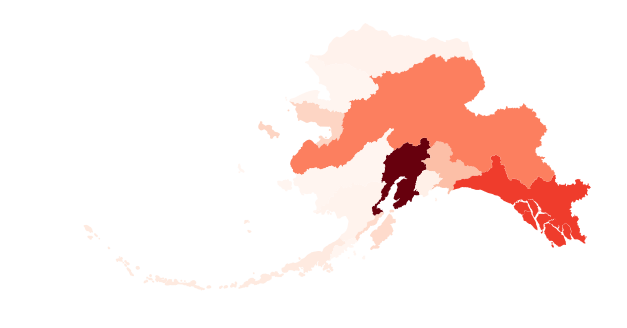

In [85]:
fig, ax = subplots(1,1,figsize=(10,10))
ax = final_gdf.plot(column='Red', cmap='Reds', ax=ax, linewidth=0.4)
ax.set_axis_off()
boo = ax.axes.set_aspect('equal')

In [86]:
final_gdf.sort_values(by='Red', ascending=False).head()

,region_id,geometry,Black,Green,Gray,Red,RedandGray
region,,,,,,,
Cook Inlet,9,"(POLYGON ((35214.97605528703 1002456.87086566,...",72,302,213,474,687
Southeast,12,(POLYGON ((1287776.763303712 744574.0859671865...,35,201,193,296,489
Yukon,13,POLYGON ((-375317.9778843221 1473997.623078777...,30,123,72,206,278
Copper River,5,"POLYGON ((561012.0068005103 1148300.750064242,...",0,31,62,112,174
Norton Sound,10,(POLYGON ((-848356.9600070229 1636692.01922057...,2,9,19,76,95


RGGRating __Green__ has no impact on fish passage.

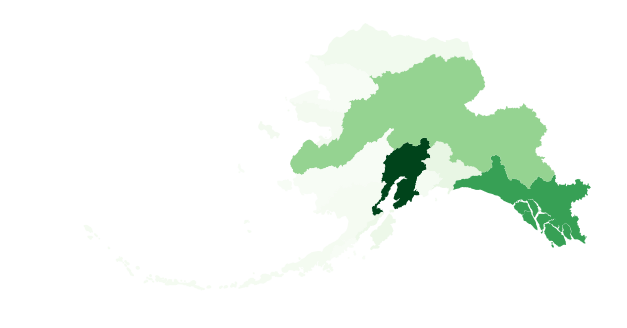

In [87]:
fig, ax = subplots(1,1,figsize=(10,10))
ax = final_gdf.plot(column='Green', cmap='Greens', ax=ax, linewidth=0.4)
ax.set_axis_off()
boo = ax.axes.set_aspect('equal')

In [88]:
final_gdf.sort_values(by='Green', ascending=False).head()

,region_id,geometry,Black,Green,Gray,Red,RedandGray
region,,,,,,,
Cook Inlet,9,"(POLYGON ((35214.97605528703 1002456.87086566,...",72,302,213,474,687
Southeast,12,(POLYGON ((1287776.763303712 744574.0859671865...,35,201,193,296,489
Yukon,13,POLYGON ((-375317.9778843221 1473997.623078777...,30,123,72,206,278
Copper River,5,"POLYGON ((561012.0068005103 1148300.750064242,...",0,31,62,112,174
Kodiak,6,(POLYGON ((115112.5187827438 983292.9990368463...,75,22,25,67,92
